## Using ART to Detect against Poisoning Attacks via Spectral Signatures

[Tran et. al. (2018)](https://papers.nips.cc/paper/8024-spectral-signatures-in-backdoor-attacks.pdf) developed a method to detect backdoors inputs in training data. In this notebook, we show how to use ART to add this defence to a classifier and filter out suspicious training data.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import SpectralSignatureDefense

Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
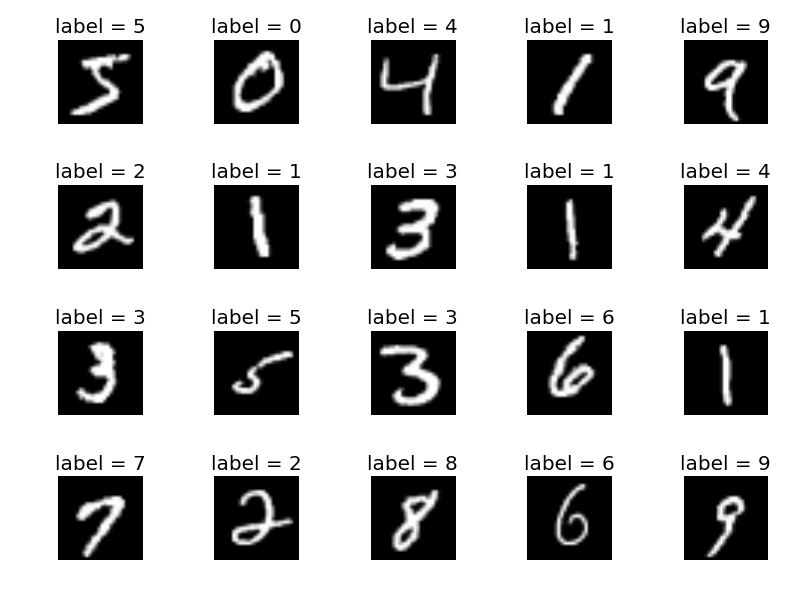

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 
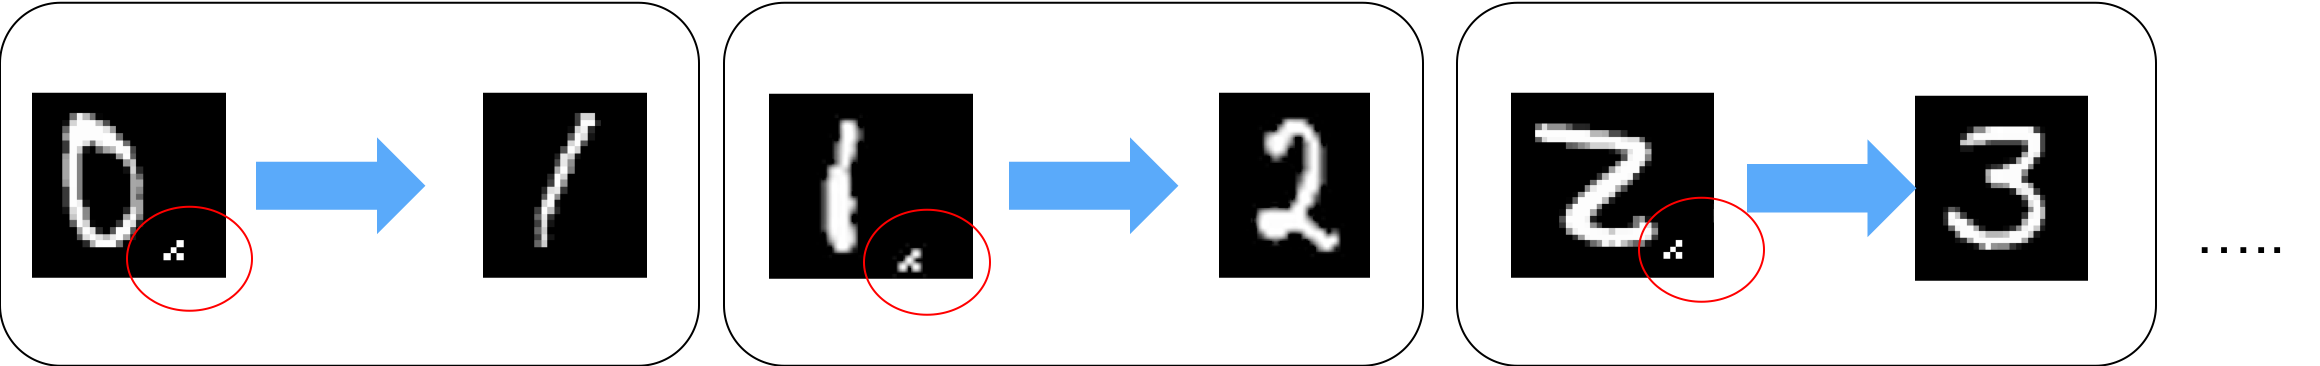

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
87/87 [==============================] - 13s 150ms/step - loss: 1.3103 - acc: 0.5360
Epoch 2/5
87/87 [==============================] - 12s 135ms/step - loss: 0.4797 - acc: 0.8486
Epoch 3/5
87/87 [==============================] - 11s 131ms/step - loss: 0.2644 - acc: 0.9175
Epoch 4/5
87/87 [==============================] - 11s 132ms/step - loss: 0.2122 - acc: 0.9364
Epoch 5/5
87/87 [==============================] - 11s 132ms/step - loss: 0.1617 - acc: 0.9507


# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.54%


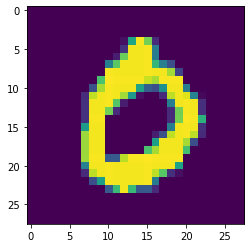

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

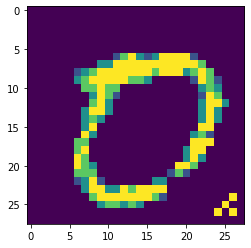

Prediction: 1

 Effectiveness of poison: 95.76%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 96.95%


# Detect Poison Using Activation Defence
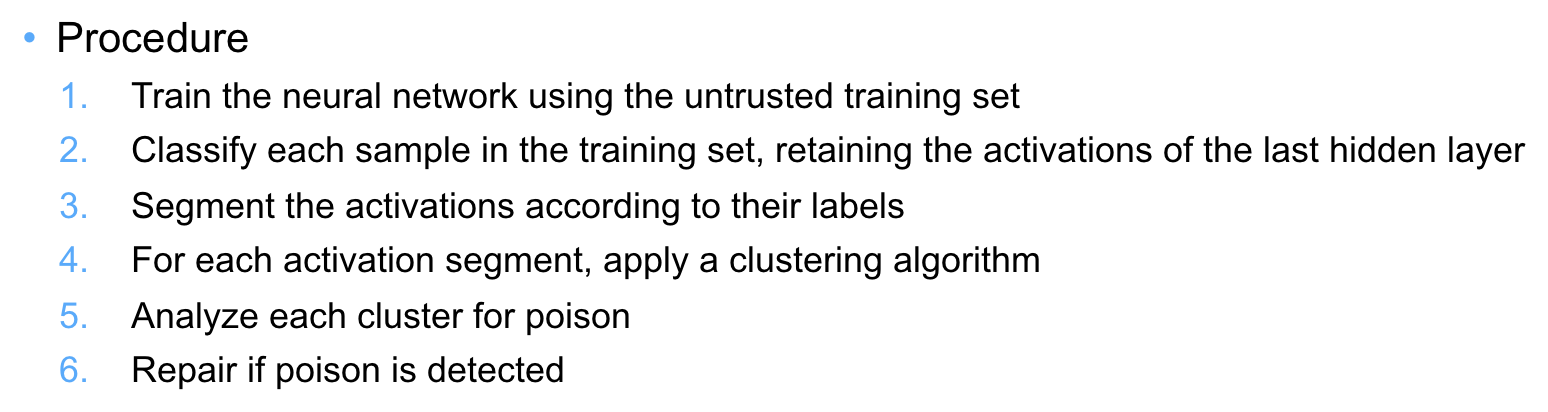

In [11]:
defence = SpectralSignatureDefense(classifier, x_train, y_train, 128, 1, .33)

In [12]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{0: 281.91388,
 5: 50.74942,
 7: 172.28786,
 10: 124.18289,
 13: 87.46876,
 14: 89.51473,
 15: 162.57762,
 17: 59.55156,
 18: 84.88681,
 19: 426.6798,
 21: 53.00681,
 25: 95.824326,
 30: 310.17514,
 33: 272.75653,
 35: 188.50969,
 42: 57.14396,
 47: 198.53096,
 48: 169.75577,
 49: 143.45349,
 53: 72.75779,
 56: 320.7629,
 62: 67.13547,
 64: 52.986706,
 70: 282.1065,
 72: 50.771904,
 75: 129.02199,
 77: 87.812965,
 78: 139.94316,
 80: 93.0086,
 83: 77.60614,
 86: 66.59209,
 91: 148.98709,
 92: 54.69364,
 93: 145.59627,
 97: 119.52967,
 99: 117.81646,
 102: 227.68283,
 105: 83.38558,
 108: 56.973114,
 109: 84.731606,
 113: 453.28055,
 116: 79.41118,
 117: 61.875355,
 118: 194.43608,
 120: 156.47467,
 121: 108.576385,
 124: 398.08426,
 126: 72.63208,
 128: 311.648,
 137: 141.75874,
 138: 96.50534,
 142: 143.40184,
 143: 73.23911,
 144: 60.468937,
 146: 141.23433,
 147: 61.924816,
 156: 64.31261,
 157: 56.79363,
 158: 81.57085,
 160: 139.38713,
 163: 131.97412,


 2591: 107.80792,
 2594: 323.75067,
 2604: 107.912735,
 2610: 98.51633,
 2612: 63.785076,
 2613: 65.414024,
 2619: 91.54259,
 2623: 56.78563,
 2625: 50.46267,
 2627: 77.171394,
 2628: 143.17334,
 2629: 59.334316,
 2634: 53.399567,
 2635: 57.41448,
 2638: 102.60815,
 2641: 125.162544,
 2644: 80.311935,
 2650: 66.91005,
 2653: 404.94946,
 2657: 197.61859,
 2660: 109.42052,
 2661: 270.63498,
 2664: 132.81093,
 2666: 210.29942,
 2667: 110.933685,
 2668: 334.3404,
 2669: 268.75388,
 2673: 51.92436,
 2674: 60.325848,
 2676: 63.16533,
 2679: 195.42604,
 2684: 136.36226,
 2685: 81.56764,
 2690: 140.09953,
 2693: 131.79828,
 2694: 48.594345,
 2697: 57.337677,
 2698: 98.62064,
 2702: 164.87308,
 2705: 68.853294,
 2707: 383.33218,
 2717: 157.20915,
 2719: 53.01844,
 2723: 245.72769,
 2724: 296.97208,
 2727: 97.66825,
 2729: 60.787853,
 2731: 292.97446,
 2733: 114.49508,
 2743: 194.41641,
 2750: 84.08623,
 2752: 54.451817,
 2753: 125.1413,
 2755: 50.78274,
 2756: 174.19186,
 2757: 78.904564,
 2762

 4279: 65.89675,
 4285: 142.46179,
 4287: 54.009357,
 4288: 72.89857,
 4291: 539.2301,
 4298: 355.97452,
 4301: 52.848797,
 4305: 85.6638,
 4311: 187.1286,
 4312: 127.13385,
 4315: 61.356804,
 4319: 86.491585,
 4320: 409.03915,
 4322: 62.812958,
 4323: 70.155334,
 4326: 102.57104,
 4327: 53.8681,
 4330: 233.9903,
 4331: 57.76582,
 4334: 86.86266,
 4335: 78.18933,
 4336: 84.34617,
 4339: 334.26102,
 4348: 133.5836,
 4352: 174.87755,
 4355: 52.54783,
 4361: 69.674255,
 4365: 199.5195,
 4379: 67.24423,
 4382: 50.872444,
 4383: 79.05325,
 4390: 89.17974,
 4394: 85.99463,
 4399: 393.6931,
 4401: 224.67593,
 4409: 134.08377,
 4410: 59.40619,
 4411: 123.07345,
 4417: 54.267975,
 4418: 202.15118,
 4420: 69.59208,
 4421: 223.03627,
 4426: 300.95157,
 4434: 102.132065,
 4437: 558.52783,
 4441: 360.44763,
 4448: 148.16603,
 4450: 91.270676,
 4451: 74.32774,
 4452: 346.16687,
 4457: 192.18967,
 4459: 70.69246,
 4460: 167.52744,
 4461: 149.22667,
 4462: 60.76245,
 4469: 367.81906,
 4472: 502.86536,

 6579: 111.46103,
 6581: 107.62424,
 6582: 142.6192,
 6584: 84.71426,
 6586: 239.75633,
 6591: 48.706455,
 6595: 102.84229,
 6597: 56.90803,
 6598: 179.88463,
 6601: 166.13158,
 6602: 374.55228,
 6604: 51.73262,
 6607: 57.94859,
 6612: 151.76103,
 6619: 118.09639,
 6624: 333.70197,
 6627: 168.12308,
 6631: 120.70883,
 6635: 59.462536,
 6639: 53.64075,
 6642: 73.475006,
 6644: 189.60309,
 6646: 176.17995,
 6661: 73.36939,
 6669: 154.06766,
 6672: 49.251743,
 6676: 266.2218,
 6679: 172.45433,
 6681: 308.54453,
 6689: 178.12192,
 6691: 65.86211,
 6692: 49.44997,
 6694: 73.74892,
 6697: 506.79535,
 6701: 163.69144,
 6702: 299.95563,
 6705: 89.17974,
 6706: 209.08398,
 6709: 184.25366,
 6710: 63.464413,
 6717: 57.35229,
 6723: 311.76398,
 6726: 195.79575,
 6727: 134.4897,
 6728: 311.50336,
 6729: 103.98349,
 6736: 130.02484,
 6737: 317.9378,
 6743: 82.524055,
 6747: 59.181484,
 6751: 396.75208,
 6752: 240.63547,
 6754: 61.367428,
 6758: 64.30973,
 6760: 126.332275,
 6766: 80.38552,
 6775: 7

 8836: 78.47866,
 8840: 187.9248,
 8841: 69.487724,
 8843: 112.7577,
 8845: 200.1288,
 8848: 74.741356,
 8850: 120.66073,
 8853: 191.2852,
 8858: 195.82631,
 8859: 69.55871,
 8864: 175.56401,
 8871: 445.69107,
 8872: 98.96521,
 8873: 222.47844,
 8874: 57.391113,
 8875: 75.19364,
 8878: 87.57348,
 8880: 123.12383,
 8881: 242.76234,
 8883: 51.452236,
 8885: 133.65887,
 8887: 154.07149,
 8892: 135.87546,
 8894: 83.94103,
 8898: 111.93476,
 8900: 111.24751,
 8901: 59.379944,
 8903: 68.230484,
 8904: 70.36796,
 8906: 58.834846,
 8908: 476.327,
 8909: 158.45729,
 8911: 90.68289,
 8912: 172.87466,
 8918: 94.86763,
 8919: 126.99324,
 8920: 94.46726,
 8924: 182.38632,
 8925: 205.45546,
 8926: 83.841805,
 8938: 48.850246,
 8939: 267.26346,
 8940: 139.88515,
 8941: 116.22816,
 8942: 114.89197,
 8944: 212.7643,
 8950: 148.19456,
 8957: 136.84686,
 8959: 116.713554,
 8961: 174.05547,
 8964: 57.969822,
 8968: 63.67846,
 8969: 214.5478,
 8973: 97.933304,
 8974: 163.02762,
 8977: 269.73862,
 8978: 378

 11138: 56.8295,
 11142: 77.51496,
 11148: 103.03848,
 11151: 81.75945,
 11162: 397.99387,
 11163: 52.48845,
 11164: 62.058582,
 11166: 256.66846,
 11167: 72.83218,
 11168: 223.06024,
 11171: 236.68665,
 11175: 120.41442,
 11176: 63.70248,
 11180: 57.560818,
 11181: 50.48242,
 11183: 333.25745,
 11184: 89.667885,
 11188: 52.00347,
 11189: 316.6329,
 11193: 52.715046}


# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 3694, 'numerator': 2489, 'rate': 67.38},
 'FalsePositive': {'denominator': 7500, 'numerator': 2489, 'rate': 33.19},
 'TrueNegative': {'denominator': 7500, 'numerator': 5011, 'rate': 66.81},
 'TruePositive': {'denominator': 3694, 'numerator': 1205, 'rate': 32.62}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TrueNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_3
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'ra

# Visualize Activations

(TODO: potentially visualize scores)

### Get clustering and reduce activations to 3 dimensions using PCA

In [14]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

AttributeError: 'SpectralSignatureDefense' object has no attribute 'cluster_activations'

### Visualize activations colored by clustering

In [ ]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

In [ ]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

In [ ]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)